In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
tf.__version__

'2.0.0'

In [7]:
%timeit train_path = glob.glob('/Users/mac/PycharmProjects/dc_2000/train/*/*.jpg')
%timeit test_path = glob.glob('/Users/mac/PycharmProjects/dc_2000/test/*/*.jpg')

6.93 ms ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.51 ms ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
train_count = len(train_path)
test_count = len(test_path)

In [5]:
train_count, test_count

(2000, 1000)

In [6]:
train_path[:5]

['/Users/mac/PycharmProjects/dc_2000/train/cat/cat.952.jpg',
 '/Users/mac/PycharmProjects/dc_2000/train/cat/cat.946.jpg',
 '/Users/mac/PycharmProjects/dc_2000/train/cat/cat.6.jpg',
 '/Users/mac/PycharmProjects/dc_2000/train/cat/cat.749.jpg',
 '/Users/mac/PycharmProjects/dc_2000/train/cat/cat.991.jpg']

In [7]:
train_label = [int(path.split('/')[-2] == 'cat') for path in train_path]
test_label = [int(path.split('/')[-2] == 'cat') for path in test_path]

In [8]:
train_label[:5]

[1, 1, 1, 1, 1]

In [9]:
def load_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256,256])
    image = tf.cast(image, tf.float32)
    image = image/255
    return image, label

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_path, train_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_path, test_label))

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_dataset = train_dataset.map(load_preprocess_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(load_preprocess_image, num_parallel_calls=AUTOTUNE)

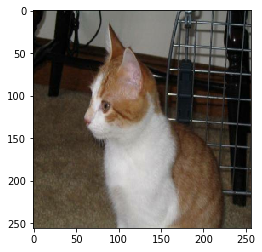

In [13]:
for img, label in train_dataset.take(1):
    plt.imshow(img)

In [14]:
BATCH_SIZE = 32

In [15]:
train_dataset = train_dataset.shuffle(train_count).repeat().batch(BATCH_SIZE)
test_dataset = test_dataset.repeat().batch(BATCH_SIZE)

In [16]:
train_dataset, test_dataset

(<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>,
 <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>)

In [17]:
conv_base = tf.keras.applications.xception.Xception(weights='imagenet',
                                                    include_top=False,
                                                    input_shape=(256,256,3),
                                                    pooling='avg')

In [18]:
conv_base.trainable=False

In [19]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [20]:
model = tf.keras.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 21,911,081
Trainable params: 1,049,601
Non-trainable params: 20,861,480
_________________________________________________________________


In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['acc'])

In [23]:
initial_epoch=10

In [24]:
history = model.fit(
    train_dataset,
    epochs=initial_epoch,
    steps_per_epoch=train_count//BATCH_SIZE,
    validation_data=test_dataset,
    validation_steps=test_count//BATCH_SIZE
)

Train for 62 steps, validate for 31 steps
Epoch 1/10
62/62 [==============================] - 351s 6s/step - loss: 0.1609 - acc: 0.9446 - val_loss: 0.1371 - val_acc: 0.9506
Epoch 2/10
62/62 [==============================] - 363s 6s/step - loss: 0.0755 - acc: 0.9763 - val_loss: 0.0932 - val_acc: 0.9647
Epoch 3/10
62/62 [==============================] - 358s 6s/step - loss: 0.0701 - acc: 0.9753 - val_loss: 0.3180 - val_acc: 0.9153
Epoch 4/10
62/62 [==============================] - 357s 6s/step - loss: 0.0714 - acc: 0.9738 - val_loss: 0.1748 - val_acc: 0.9496
Epoch 5/10
 1/62 [..............................] - ETA: 4:33

KeyboardInterrupt: 

In [25]:
conv_base.trainable = True

In [27]:
len(conv_base.layers)

133

In [28]:
fine_tune_at = -33

In [29]:
for layer in conv_base.layers[:fine_tune_at]:
    layer.trainable = False

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 12,432,737
Trainable params: 1,049,601
Non-trainable params: 11,383,136
_________________________________________________________________


In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005/10),loss='binary_crossentropy',metrics=['acc'])

In [32]:
fine_epoch = 10
total_epoch = initial_epoch + fine_epoch

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=total_epoch,
    initial_epoch=initial_epoch,
    validation_data=test_dataset,
    validation_steps=test_count//BATCH_SIZE
)